In [1]:
# R version 4.1.0 #
# Load packages: Seurat_4.1.1, RColorBrewer_1.1-3, ggplot2_3.3.6, extrafont_0.18, dplyr_1.0.9, tidyr_1.2.0
# purrr_0.3.4, stringr_1.4.0, zoo_1.8-10

packages = c('Seurat','RColorBrewer','ggplot2','extrafont','dplyr','tidyr','purrr','stringr','zoo')
for (p in packages){
    suppressPackageStartupMessages(eval(bquote(library(.(p)))))
}

bnum_table <- read.delim('source_data/included/ecoli_bnum_table_updated_2.txt',sep='\t')

get_gene_list <- function(name,seurat){
    bnums <- c()
    genes <- c()
    for (annotation_type in c('go','tf','sr')){
        data_name = str_replace("source_data/included/Ecoli_RENAME_index.txt","RENAME",annotation_type)
        data = readLines(data_name)
        for (line in data[grepl(name, data)]){
            bnum <- strsplit(line,'\t')[[1]][1]
            if (bnum %in% bnum_table[['bnum']]){
                gene <- bnum_table[bnum_table['bnum']==bnum,'gene']
                if (gene %in% rownames(seurat)){
                    bnums <- c(bnums,bnum)
                    genes <- c(genes,gene)
                }
            }
        }
    }
    return(genes)
}


In [2]:
plot_pc1 <- function(sub_seurat,cols,slot=sub_seurat$seurat_clusters,xmin,xmax) {
    umap_df <- data.frame(umap = sub_seurat$pca@cell.embeddings[,'PC_1'],type=slot)
    umap_df2 <- umap_df %>%
      nest(-type) %>%
      mutate(density = map(data, ~density(.x$umap))) %>%
      mutate(density.x = map(density, ~.x[["x"]]),
             density.y = map(density, ~.x[["y"]])) %>%
      select(type, density.x, density.y) %>%
      unnest()
    options(repr.plot.width=4.2358, repr.plot.height=1.2)
    p <- ggplot(umap_df2,aes(x = density.x, y = density.y, color = type)) + geom_line(size=1)+theme_classic()+
    scale_color_manual(labels = levels(slot),values = cols,name='') + 
    scale_fill_manual(labels = levels(slot),values = alpha(cols,1),name='') +
    xlim(xmin,xmax) +
    theme(text=element_text(family= "Arial", size=12)) + 
    theme(axis.text.x=element_blank(), #remove x axis labels
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank(),  #remove y axis ticks
        legend.position = "none",
        axis.title.x=element_blank(),
        axis.title.y=element_blank()) 
    return(p)
}

Warning message:
“Supplying `...` without names was deprecated in tidyr 1.0.0.
ℹ Please specify a name for each selection.
ℹ Did you want `data = -type`?”
Warning message:
“`cols` is now required when using `unnest()`.
ℹ Please use `cols = c(density.x, density.y)`.”
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 75 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 75 rows containing missing values or values outside the scale range (`geom_line()`).”


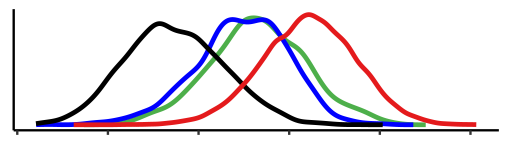

In [3]:
seurat <- readRDS('source_data/generated/fig3_persister_only.rds') # saved in fig3_persister_only.R
seurat@active.ident <- seurat$cell.group
ids = c('metG','WT_d6','hipA7','tet')
seurat <- subset(seurat,idents=ids)
seurat$cell.group <- droplevels(seurat$cell.group)

xmin = min(seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(seurat$pca@cell.embeddings[,'PC_1'])

my_cols = brewer.pal(8,"Set1")
colors = c(my_cols[3],'blue','black',my_cols[1])
plot_pc1(seurat,colors,slot=seurat$cell.group,xmin,xmax) 
ggsave('figures/fig3c_top.pdf',width = 4.2358,height = 1.2) # colors changed in illustrator


In [4]:
write.table(seurat$pca@feature.loadings[,'PC_1'],'source_data/generated/fig3_pc1_loadings.txt',sep='\t',quote=FALSE)


Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


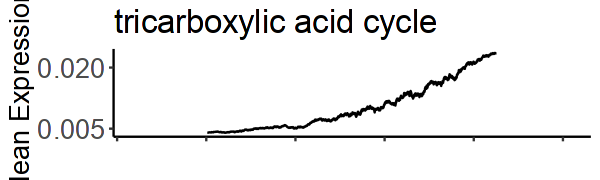

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


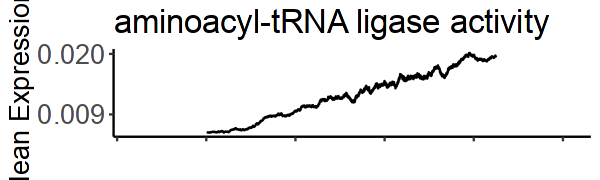

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


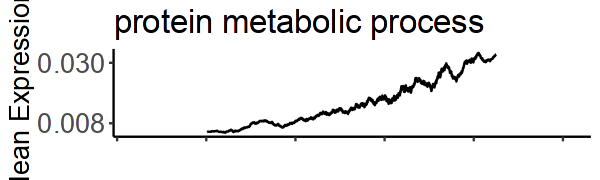

Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”
Warning message:
“Removed 999 rows containing missing values or values outside the scale range (`geom_line()`).”


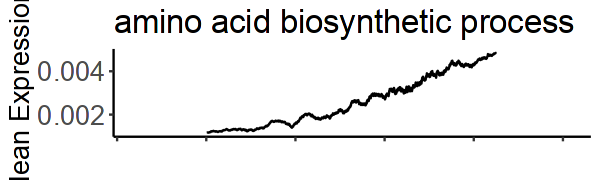

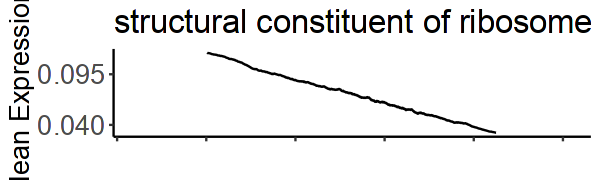

In [5]:
selected_terms <- c('GO:0006099','GO:0004812','GO:0019538','GO:0008652','GO:0003735') ## from figure3_py notebook
names <- c('tricarboxylic acid cycle','aminoacyl-tRNA ligase activity','protein metabolic process','amino acid biosynthetic process','structural constituent of ribosome')
options(repr.plot.width=5, repr.plot.height=1.5)
seurat@active.ident <- seurat$cell.group
xmin = min(seurat$pca@cell.embeddings[,'PC_1'])
xmax = max(seurat$pca@cell.embeddings[,'PC_1'])
ymins = c(0.005,0.009,0.008,0.002,0.04)
ymaxs = c(0.02,0.02,0.03,0.004,0.095)

for (i in 1:length(selected_terms)){
    my_cols = brewer.pal(10,"Spectral")
    marker_list <- get_gene_list(str_split(selected_terms[i],' ',simplify=TRUE)[1],seurat) ## all bnums in term
    marker_list <- unique(marker_list)
    seurat$new.feat <- colMeans(seurat$RNA@data[marker_list,])
    l = seurat$new.feat[order(seurat$pca@cell.embeddings[,'PC_1'])]
    pc = seurat$pca@cell.embeddings[,'PC_1'][order(seurat$pca@cell.embeddings[,'PC_1'])]
    k = 1000
    df <- data.frame(l)
    df$pc <- pc
    df <- df %>%
        mutate(avg_exp = rollmean(l, k=k, fill=NA, align='right')) %>%
        mutate(avg_pc = rollmean(pc, k=k, fill=NA, align='right'))
#     print(quantile(df$avg_exp, probs = c(0.1),na.rm=TRUE))
#     print(quantile(df$avg_exp, probs = c(0.9),na.rm=TRUE))
    p <- ggplot(df, aes(x=avg_pc, y=avg_exp)) + geom_line() + theme_classic() + ggtitle(names[i])
    p <- p + theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16),axis.text.x=element_blank(),legend.position='none')
    p <- p + xlab('') + ylab('Mean Expression') + xlim(xmin,xmax) + scale_y_continuous(breaks=c(ymins[i],ymaxs[i]))
    p <- p + theme(text=element_text(family= "Arial", size=16),axis.text=element_text(family='Arial',size=16))

    print(p)
    filename = paste('figures/fig3c_',str_replace(str_split(selected_terms[i],' ',simplify=TRUE)[1],':','_'),'.pdf',sep='')
    ggsave(filename,width = 5.06,height = 1.5)
}